In [1]:
import pandas as pd
from datetime import datetime
from tqdm.notebook import tqdm
import pandas_profiling
import numpy as np

from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
import phik

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

register_matplotlib_converters()
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9 #Changes default matplotlib plots to this size

In [5]:
raw_data = pd.read_csv('./actuals.csv')
timestamp = []

for row in tqdm(raw_data.timestamp.tolist()):

    tstamp = datetime.strptime(row,'%d/%b/%Y %H:%M')
    timestamp.append(tstamp)
    
raw_data['timestamp'] = timestamp
df = raw_data
df.set_index('timestamp',inplace=True)
df.index = pd.to_datetime(raw_data.index, format='%Y-%m-%d %H:%M:%S')

df.columns = ['load', 't1', 't2', 't3']
# df['dow'] = df.index.dayofweek
# df['doy'] = df.index.dayofyear
df['year'] = df.index.year
# df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name()
df['woy'] = df.index.weekofyear
df['dom'] = df.index.day # Day of Month
# df['date'] = df.index.date 

In [6]:
pandas_profiling.ProfileReport(df)

## Inference from the profiling

### Correlation:
The correlation matrix indicates the variables "t1,t2,t3,dow,doy ,woy ,month" has a high correlation with the energy consumption (load) in Phik correlation


### Descriptive statistics
Skewness is a measure of a dataset's symmetry or lack of symmetry. Perfectly symmetric data (normal distribution) would have a skewness of 0.As can be seen the skewness is greater than 1 which tells us that data is highly skewed.

Reference: https://towardsdatascience.com/skewed-data-a-problem-to-your-statistical-model-9a6b5bb74e37

So in skewed data, the tail region may act as an outlier for the statistical model and we know that outliers adversely affect the model’s performance especially regression-based models. There are statistical model that are robust to outlier like a Tree-based models but it will limit the possibility to try other models. So there is a necessity to transform the skewed data to close enough to a Gaussian distribution or Normal distribution. This will allow us to try more number of statistical model.

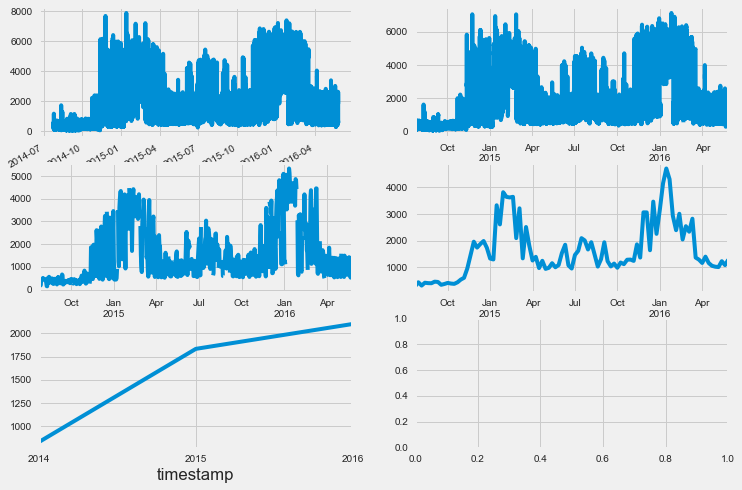

In [8]:
fig, axes = plt.subplots(3,2)

hourly_data = df.resample(rule='h').mean()
hourly_data = hourly_data.asfreq('h')

daily_data = df.resample(rule='d').mean()
daily_data = daily_data.asfreq('d')

weekly_data = df.resample(rule='w').mean()
weekly_data = weekly_data.asfreq('w')

yearly_data = df.resample(rule='y').mean()
yearly_data = yearly_data.asfreq('y')

df['load'].plot(ax=axes[0,0])

hourly_data['load'].plot(ax=axes[0,1])

daily_data['load'].plot(ax=axes[1,0])

weekly_data['load'].plot(ax=axes[1,1])

yearly_data['load'].plot(ax=axes[2,0])

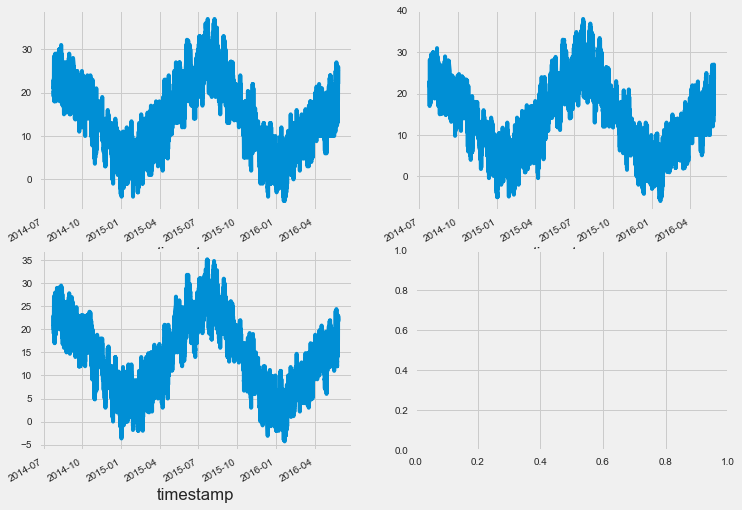

In [9]:
fig, axes = plt.subplots(2,2)

df['t1'].plot(ax=axes[0,0])
df['t2'].plot(ax=axes[0,1])
df['t3'].plot(ax=axes[1,0])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8623b1d10>,
      dtype=object)

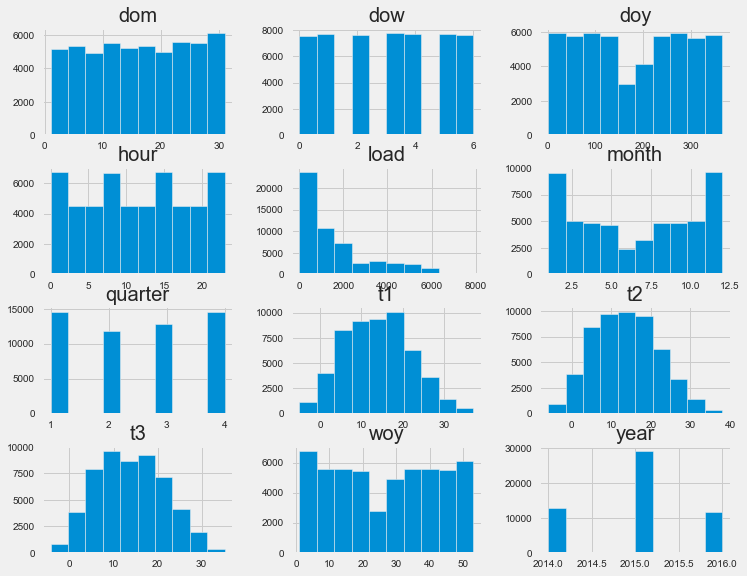

In [10]:
df.hist()

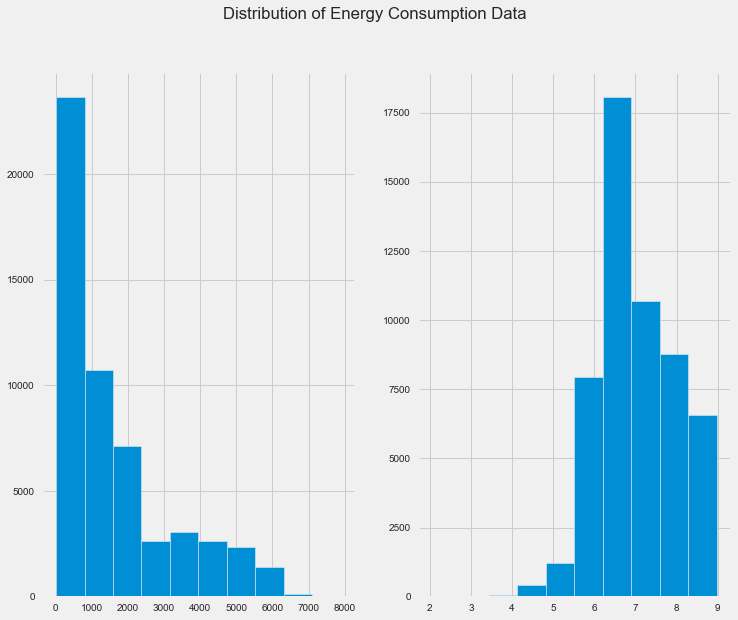

In [11]:
dataNormal = pd.Series(df['load'].apply(np.log))
dataDefault = pd.Series(df['load'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Distribution of Energy Consumption Data')
dataDefault.hist(ax=ax1)
dataNormal.hist(ax=ax2)

Text(0.5, 1.0, 'Heatmap - by Hour of Day')

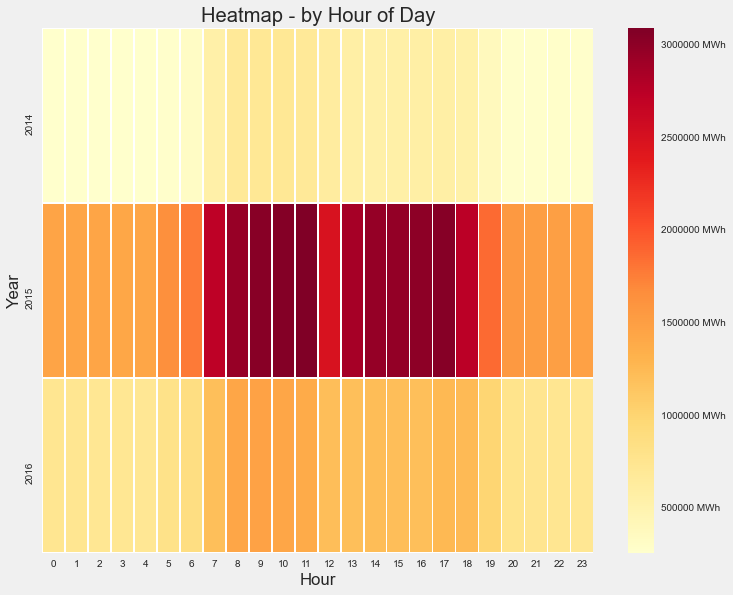

In [12]:
heatmap_data = df.copy()

# First we need to add weekdays as a column
heatmap_data['Hour'] = df.index.hour

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Hour']).sum()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# We drop off 2018 because it's not a full year
# heatmap_data = heatmap_data[heatmap_data['Year'] != 2018]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Hour', values='load')

heatmap_data.head(100)
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Hour of Day')

/Users/siddesh.suseela/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


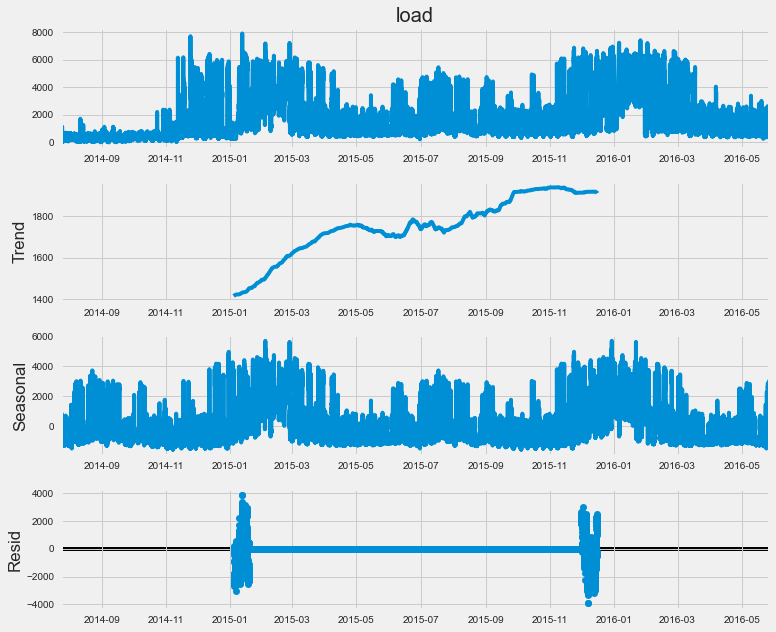

In [13]:
series = df['load']
frequency = 24*365*3

# decomposing the time-series, with the frequency being 24 hours per 365 days
decomposed = seasonal_decompose(series, model='additive', period=frequency)
fig = decomposed.plot()
fig.show()

In [15]:
np.all(np.isfinite(hourly_data.load))

False

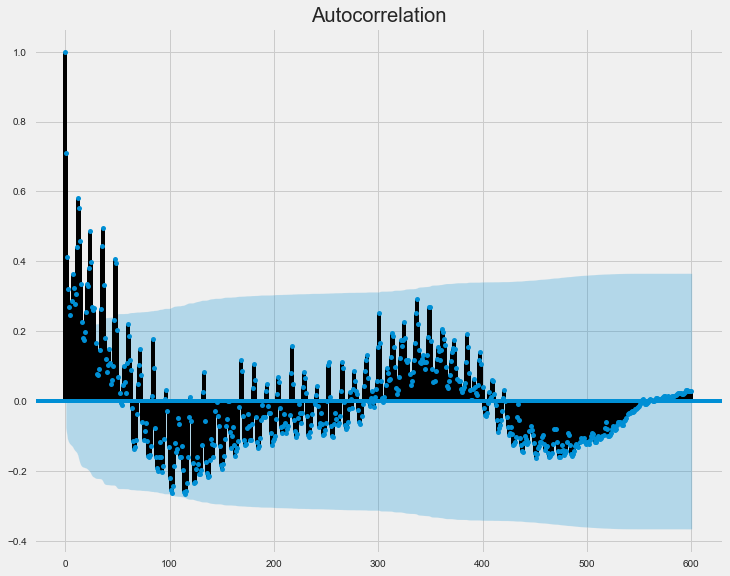

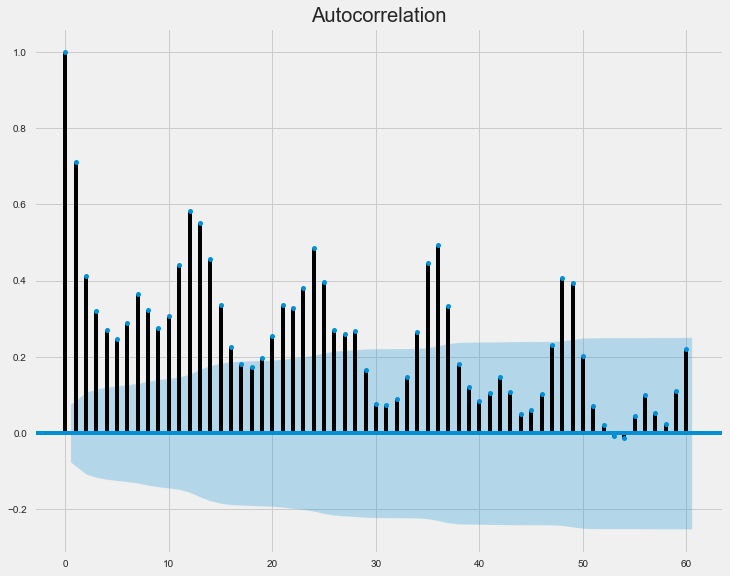

In [9]:
daily_data = df.resample(rule='D').sum()
daily_data = daily_data.asfreq('D')
daily_data = daily_data.drop([daily_data.index.min(), daily_data.index.max()])

plot_acf(daily_data['load'],lags=600) 
plot_acf(daily_data['load'],lags=60)
plt.show()

# Inference

As seen from the above graphs, there is a significant correlation every 12 day interval and thus is potentially useful to select the lag window during feature engineering